In [1]:
import tensorflow as tf
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import (Add, Conv2D, Dense, Flatten, Input,
                                     Lambda, Subtract)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np

from vans_gym.envs import VansEnv
from vans_gym.solvers import CirqSolver, VAnsatz
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt

In [9]:
def build_q_network(solver, learning_rate=0.01):
    n_actions = len(solver.alphabet)
    model_input = Input(shape=(solver.n_qubits))
    x = Lambda(lambda layer: layer / n_actions)(model_input)
    
    x = Dense(64, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(model_input)
    x = Dense(128, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(x)
    x = Dense(128, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(x)

    # Split into value and advantage streams
    val_stream, adv_stream = Lambda(lambda w: tf.split(w, 2, 1))(x)  # custom splitting layer

    val_stream = Flatten()(val_stream)
    val = Dense(1, kernel_initializer=VarianceScaling(scale=2.))(val_stream)

    adv_stream = Flatten()(adv_stream)
    adv = Dense(n_actions, kernel_initializer=VarianceScaling(scale=2.))(adv_stream)

    ###https://arxiv.org/pdf/1511.06581.pdf###
    # Combine streams into Q-Values On the one hand this loses the 
    #original semantics ofVandAbecause  they  are  now  off-target  
    #by  a  constant,  but  onthe other hand it increases the stability 
    #of the optimization:with (9) the advantages only need to change 
    #as fast as themean, instead of having to compensate any change to the
    #optimal action’s advantage in (8).  
    
    reduce_mean = Lambda(lambda w: tf.reduce_mean(w, axis=1, keepdims=True))  # custom layer for reduce mean
    q_vals = Add()([val, Subtract()([adv, reduce_mean(adv)])])

    # Build model
    model = Model(model_input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber())

    return model


def update_target_parameters(target_net,primary_net, tau=0.01):
    prim_weights = primary_net.get_weights()
    targ_weights = target_net.get_weights()
    weights = []
    for i in tf.range(len(prim_weights)):
        weights.append(tau * prim_weights[i] + (1 - tau) * targ_weights[i])
    target_net.set_weights(weights)
    return


class ReplayBuffer:
    def __init__(self, solver, size=10**2, use_per=True):
        self.size = size
        self.count = 0  # total index of memory written to, always less than self.size
        self.current = 0  # index to write to
        self.state_shape = solver.state_length

        # Pre-allocate memory
        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.states = np.empty((self.size, 2, self.state_shape ), dtype=np.float32)
        self.terminal_flags = np.empty(self.size, dtype=np.bool)
        self.priorities = np.zeros(self.size, dtype=np.float32)
        self.use_per = use_per
        
    def add_experience(self, action, states, reward, terminal):

        self.actions[self.current] = action
        self.states[self.current] = states
        self.rewards[self.current] = reward
        self.terminal_flags[self.current] = terminal
        self.priorities[self.current] = max(self.priorities.max(), 1)  # make the most recent experience important
        self.count = max(self.count, self.current+1) #
        self.current = (self.current + 1) % self.size #
        
    def get_minibatch(self, batch_size=32, priority_scale=0.7):
        """Returns a minibatch of self.batch_size = 32 transitions
        Arguments:
            batch_size: How many samples to return
            priority_scale: How much to weight priorities. 0 = completely random, 1 = completely based on priority
        Returns:
            A tuple of states, actions, rewards, new_states, and terminals
            If use_per is True:
                An array describing the importance of transition. Used for scaling gradient steps.
                An array of each index that was sampled
        """

        # Get sampling probabilities from priority list
        if self.use_per:
            scaled_priorities = self.priorities[:self.count] ** priority_scale
            sample_probabilities = scaled_priorities / sum(scaled_priorities)

        # Get a list of valid indices
        indices = []
        for i in range(batch_size):
            # Get a random number from history_length to maximum frame written with probabilities based on priority weights
            if self.use_per:
                index = np.random.choice(np.arange(self.count), p=sample_probabilities)
            else:
                index = random.randint(0,self.count - 1)
            indices.append(index)

        # Retrieve states from memory
        states = []
        new_states = []
        for idx in indices:
            states.append(self.states[idx][0])
            new_states.append(self.states[idx][1])

        if self.use_per:
            # Get importance weights from probabilities calculated earlier
            importance = 1/self.count * 1/sample_probabilities[[index for index in indices]]
            importance = importance / importance.max()
            return (states, self.actions[indices], self.rewards[indices], new_states, self.terminal_flags[indices]), importance, indices
        else:
            return states, self.actions[indices], self.rewards[indices], new_states, self.terminal_flags[indices]

    def set_priorities(self, indices, errors, offset=0.1):
        """Update priorities for PER
        Arguments:
            indices: Indices to update
            errors: For each index, the error between the target Q-vals and the predicted Q-vals
        """
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def save(self, folder_name):
        """Save the replay buffer to a folder"""

        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)

        np.save(folder_name + '/actions.npy', self.actions)
        np.save(folder_name + '/frames.npy', self.states)
        np.save(folder_name + '/rewards.npy', self.rewards)
        np.save(folder_name + '/terminal_flags.npy', self.terminal_flags)
        np.save(folder_name+"/priorities.npy", self.priorities)

    def load(self, folder_name):
        """Loads the replay buffer from a folder"""
        self.actions = np.load(folder_name + '/actions.npy')
        self.states = np.load(folder_name + '/frames.npy')
        self.rewards = np.load(folder_name + '/rewards.npy')
        self.terminal_flags = np.load(folder_name + '/terminal_flags.npy')
        self.count = len(self.rewards)
        self.current = len(self.rewards)
        self.priorities = np.load(folder_name+"/priorities.npy")

def learn_step(prim_qnet, target_qnet, buffer, batch_size=32):
    if buffer.use_per:
        (states, actions, rewards, nstates ,dones), importance, indices  = buffer.get_minibatch(batch_size=batch_size)
    else:
        states, actions, rewards, nstates ,dones  = buffer.get_minibatch(batch_size=batch_size)
        
    arg_q_max = prim_qnet.predict(tf.stack(states)).argmax(axis=1)
    future_q_vals = target_qnet.predict(tf.stack(nstates))
    nextq = future_q_vals[range(batch_size), arg_q_max]
    target_q = rewards + (1-dones)*nextq
    with tf.GradientTape() as tape:
        tape.watch(prim_qnet.trainable_variables)
        qvalues = prim_qnet(tf.stack(states))
        Q = tf.reduce_sum(tf.multiply(qvalues, tf.keras.utils.to_categorical(actions, len(solver.alphabet))), axis=1)
        error = target_q - Q #this is for importance sample
        loss = tf.keras.losses.Huber()(target_q, Q)
        if buffer.use_per:
            loss = tf.reduce_mean(loss*importance)
            
    grads = tape.gradient(loss, prim_qnet.trainable_variables)
    prim_qnet.optimizer.apply_gradients(zip(grads, prim_qnet.trainable_variables))
    update_target_parameters(target_qnet,prim_qnet, tau=0.05)
    if buffer.use_per:
        buffer.set_priorities(indices, error)
    return loss.numpy()        
        
def give_action(prim_qnet,state, ep=0.01):
    if np.random.random() < ep:
        random_action = np.random.choice(range(prim_qnet.output_shape[-1]))
        return random_action
    else:
        return prim_qnet.predict(tf.expand_dims(state,axis=0)).argmax(axis=1)[0]

In [10]:
observable_name="Ising_High_TFields_HX"
solver = CirqSolver(n_qubits = 3,observable_name=observable_name)
env = VansEnv(solver,maximum_number_of_gates=solver.n_qubits, state_as_sequence=True, printing=False)
solver.state_length = env.maximum_number_of_gates
prim_qnet = build_q_network(solver, learning_rate=0.01)
target_qnet = build_q_network(solver, learning_rate=0.01)
buffer = ReplayBuffer(solver, use_per=True)


N=500
episodes = np.arange(1,N,1)
tt = .75*len(episodes)/np.log(1/0.05)
def schedule(k):
    return max(0.05, np.exp(-k/tt))


/home/cooper-cooper/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [13]:
lhist=[]
pt=[]
rcum=[]
env.reset()
cumre=0
for k in tqdm(episodes):
    done = False
    state=env.reset()
    while not done:
        action = give_action(prim_qnet, state, ep=0.1)#)schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add_experience(action, [state, next_state], reward, done)
        state = next_state
    cumre+=reward
    rcum.append(cumre)
    if k>2:
        lhist.append(learn_step(prim_qnet, target_qnet, buffer, batch_size=64))

        
    #####greedy prob#####
    state = env.reset()
    done = False
    while not done:
        action =give_action(prim_qnet,state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state
    pt.append(reward)

100%|██████████| 499/499 [01:52<00:00,  4.44it/s]


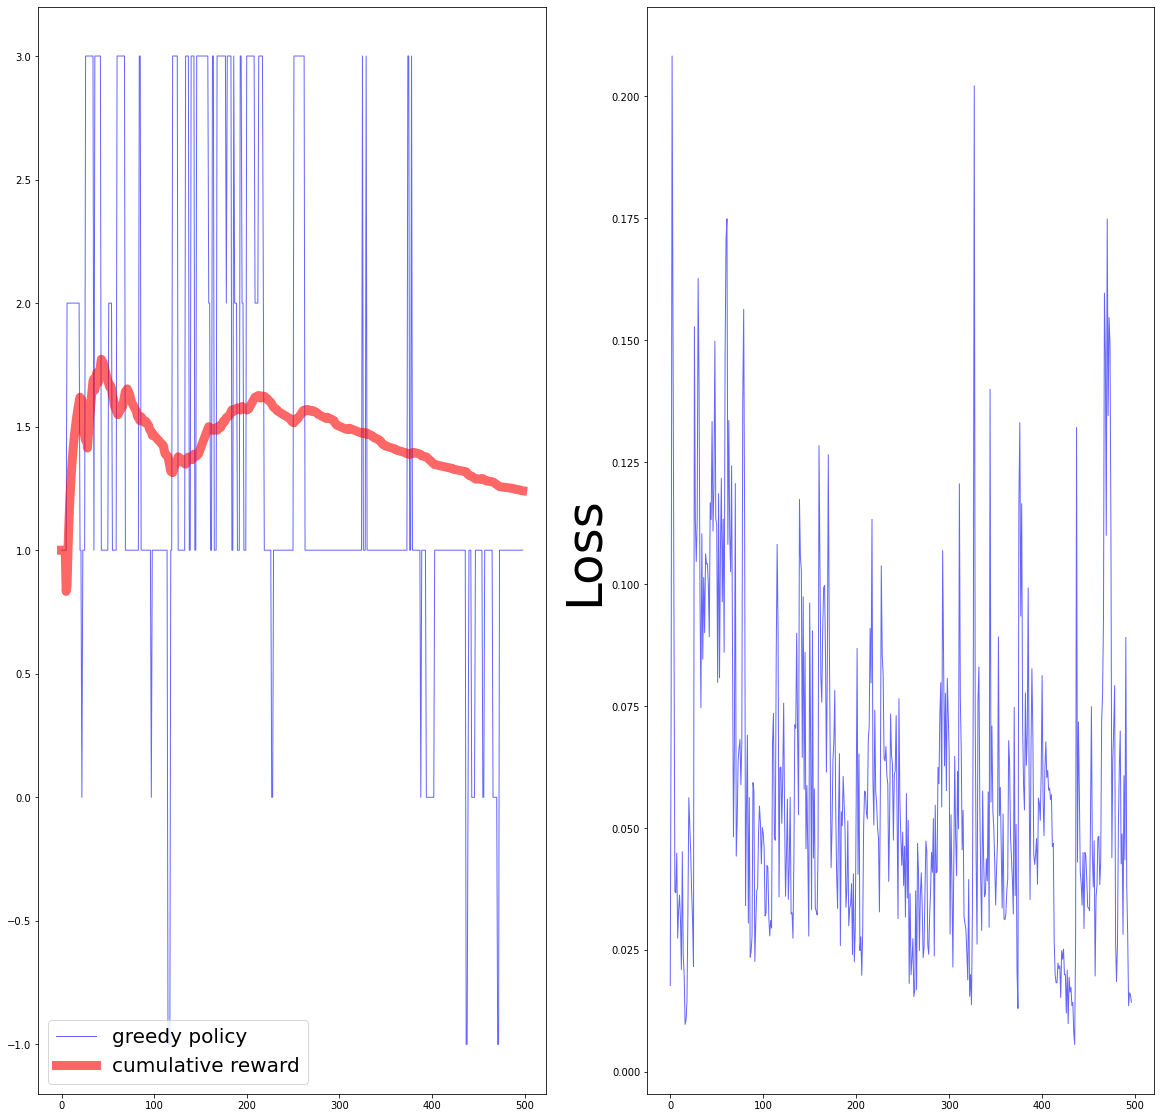

In [14]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(rcum/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax2.set_ylabel("Loss", size=50)
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")
ax1.legend(prop={"size":20})